## 데이터 분석 목적 : 다음 분기에 어떤 게임을 설계해야 할까

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('/content/drive/MyDrive/data/vgames2.csv')
df.tail()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03
16597,16598,The King of Fighters '95,PS,1996.0,Fighting,Sony Computer Entertainment,0,0,0.16,0.01


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


### 데이터 타입 변경

In [4]:
# Sales 단위 M 으로 통일하기

def column_cleaning(string):

  if 'K' in string :
    result = pd.to_numeric(string.replace('K','')) / 1000

  else :
    result = pd.to_numeric(string.replace('M',''))

  return result

df['NA_Sales'] = df['NA_Sales'].apply(column_cleaning)
df['EU_Sales'] = df['EU_Sales'].apply(column_cleaning)
df['JP_Sales'] = df['JP_Sales'].apply(column_cleaning)
df['Other_Sales'] = df['Other_Sales'].apply(column_cleaning)

### 이상치 처리

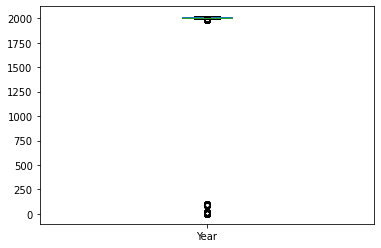

In [5]:
# 'Year' 이상치 확인

df['Year'].plot(kind = 'box')

In [6]:
# 'Year' 이상치 처리

new_list = []

for i in df['Year'].values :
  if i <= 21 :
    i += 2000
  elif 22 < i < 250:
    i += 1900
  new_list.append(i)

df['Year'] = pd.DataFrame(new_list)

### 결측치 처리

In [7]:
df.isna().sum()

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [8]:
# 전체 데이터 개수에 비해 결측치 수가 적으므로 결측치 제거
df.dropna(inplace=True)
df.shape

(16241, 10)

In [9]:
df['Year'] = df['Year'].map(int) # Year 데이터 타입 int 로 변경 
df.drop('Unnamed: 0', axis =1, inplace = True) # 불필요한 칼럼 제거
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'] # 총 출고량 칼럼 생성
df.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38
16597,The King of Fighters '95,PS,1996,Fighting,Sony Computer Entertainment,0.00,0.00,0.16,0.01,0.17


In [10]:
# 범주형 칼럼의 범주 개수 파악
print(df['Platform'].unique().size, df['Platform'].unique())
print(df['Genre'].unique().size, df['Genre'].unique())
print(df['Publisher'].unique().size)
print(df['Name'].unique().size)

31 ['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
12 ['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter']
575
11295


In [11]:
# 지역별 출고량 상관 관계
df_corr = df[['NA_Sales', 'EU_Sales',	'JP_Sales',	'Other_Sales']].corr()
df_corr

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
NA_Sales,1.000000,0.768906,0.449358,0.634707
EU_Sales,0.768906,1.000000,0.432350,0.728084
JP_Sales,0.449358,0.432350,1.000000,0.285395
Other_Sales,0.634707,0.728084,0.285395,1.000000


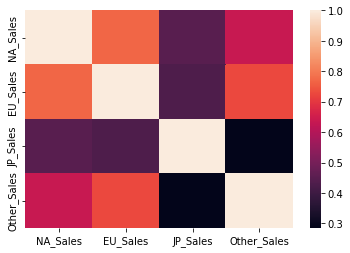

In [12]:
# 히트맵으로 시각화
# pd.plotting.scatter_matrix(df[['NA_Sales', 'EU_Sales',	'JP_Sales',	'Other_Sales']]);
sns.heatmap(df_corr); 
# 북미와 유럽, 유럽과 그외 나라의 상관관계가 높다. 
# 일본은 다른 모든 나라와 상관관계가 낮다.

## 질문 1 > 지역에 따라서 선호하는 게임 장르가 다를까?

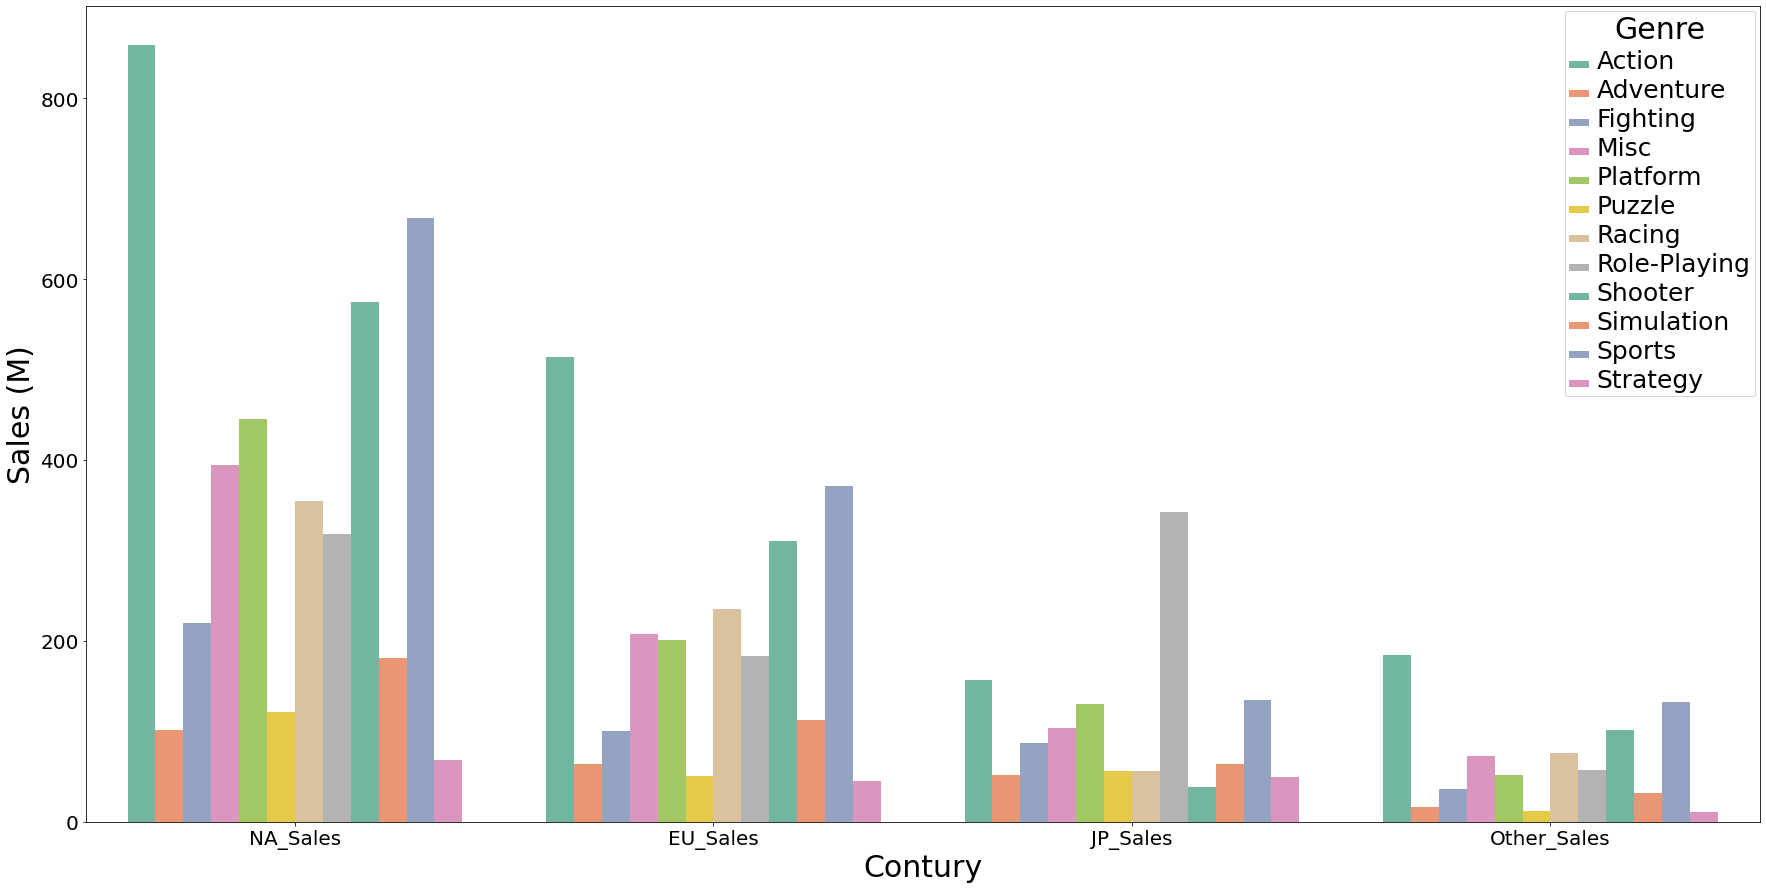

In [13]:
# 막대 그래프로 시각화
df_gen_sales = df.groupby('Genre').sum()[['NA_Sales', 'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_gen_sales_melt = df_gen_sales.reset_index().melt(id_vars = 'Genre', value_vars = ['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales'])

palette1 = sns.color_palette("Set2")
plt.figure(figsize = (30, 15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax = sns.barplot(x = 'variable', y = 'value', hue = 'Genre', data = df_gen_sales_melt, palette=palette1);
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.setp(ax.get_legend().get_title(), fontsize='30')
plt.xlabel("Contury", fontsize = 30)
plt.ylabel("Sales (M)", fontsize = 30)
sns.set_style('whitegrid')

#### 가설검정
- 지역마다 판매된 장르의 평균이 유의미한 차이가 있는가?
- 귀무 가설 : 모든 지역에서 선호하는 게임 장르의 차이가 없다.
- 대립 가설 : 최소한 한 지역 이상에서 선호하는 게임 장르의 차이를 보인다.

In [14]:
# 지역마다 판매된 장르의 평균이 유의미한 차이가 있는지 검증 (ANOVA분석)
from scipy.stats import f_oneway

f_oneway(df_gen_sales['NA_Sales'], df_gen_sales['EU_Sales'], df_gen_sales['JP_Sales'], df_gen_sales['Other_Sales'])
# p-value < 0.05 이므로 귀무가설을 기각한다. 최소한 한 지역 이상에서 선호하는 게임 장르의 차이를 보인다.

F_onewayResult(statistic=9.050217142562778, pvalue=8.797574909911202e-05)

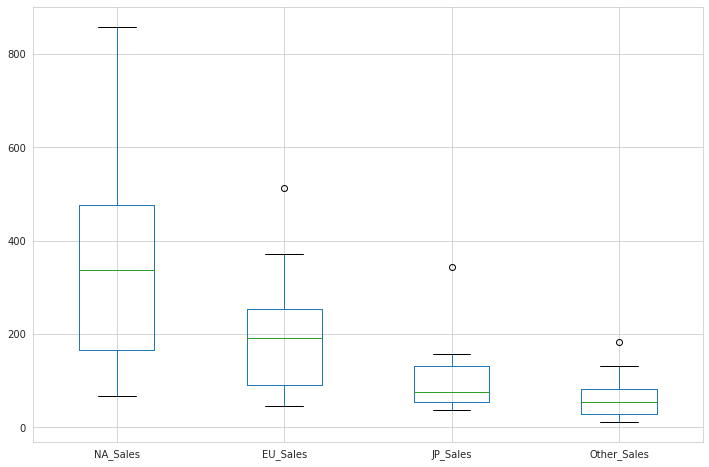

In [15]:
# 박스 플롯으로 시각화
df_gen_sales.plot.box(figsize=(12, 8));

## 질문 2 > 연도별 게임의 장르별, 플랫폼별 트렌드가 있을까?

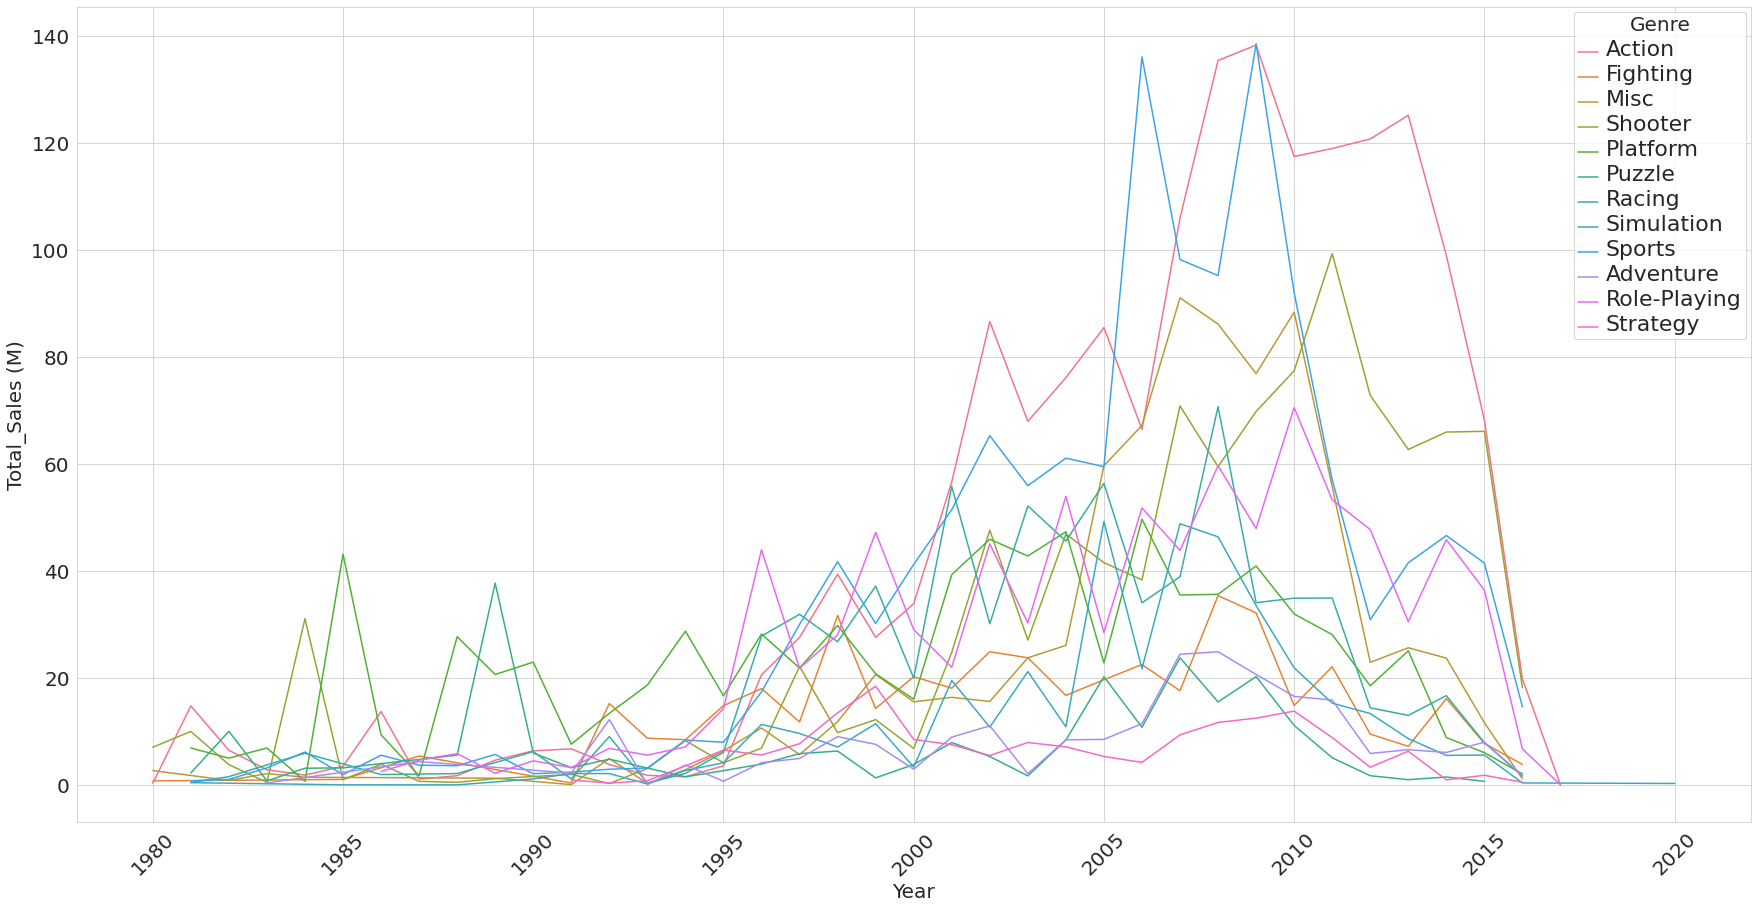

In [16]:
# 연도별 가장 많이 팔린 장르
df_yr_gen = df.groupby(['Year', 'Genre']).sum()[['Total_Sales']].reset_index()
df_yr_gen.sort_values('Genre')

# 막대 그래프로 시각화
plt.figure(figsize=(30, 15))
plt.xticks(fontsize = 20, rotation = 45)
plt.yticks(fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Total_Sales (M)", fontsize = 20)
ax = sns.lineplot(data = df_yr_gen, x= "Year", y= "Total_Sales", hue = 'Genre')
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.set_style('whitegrid')

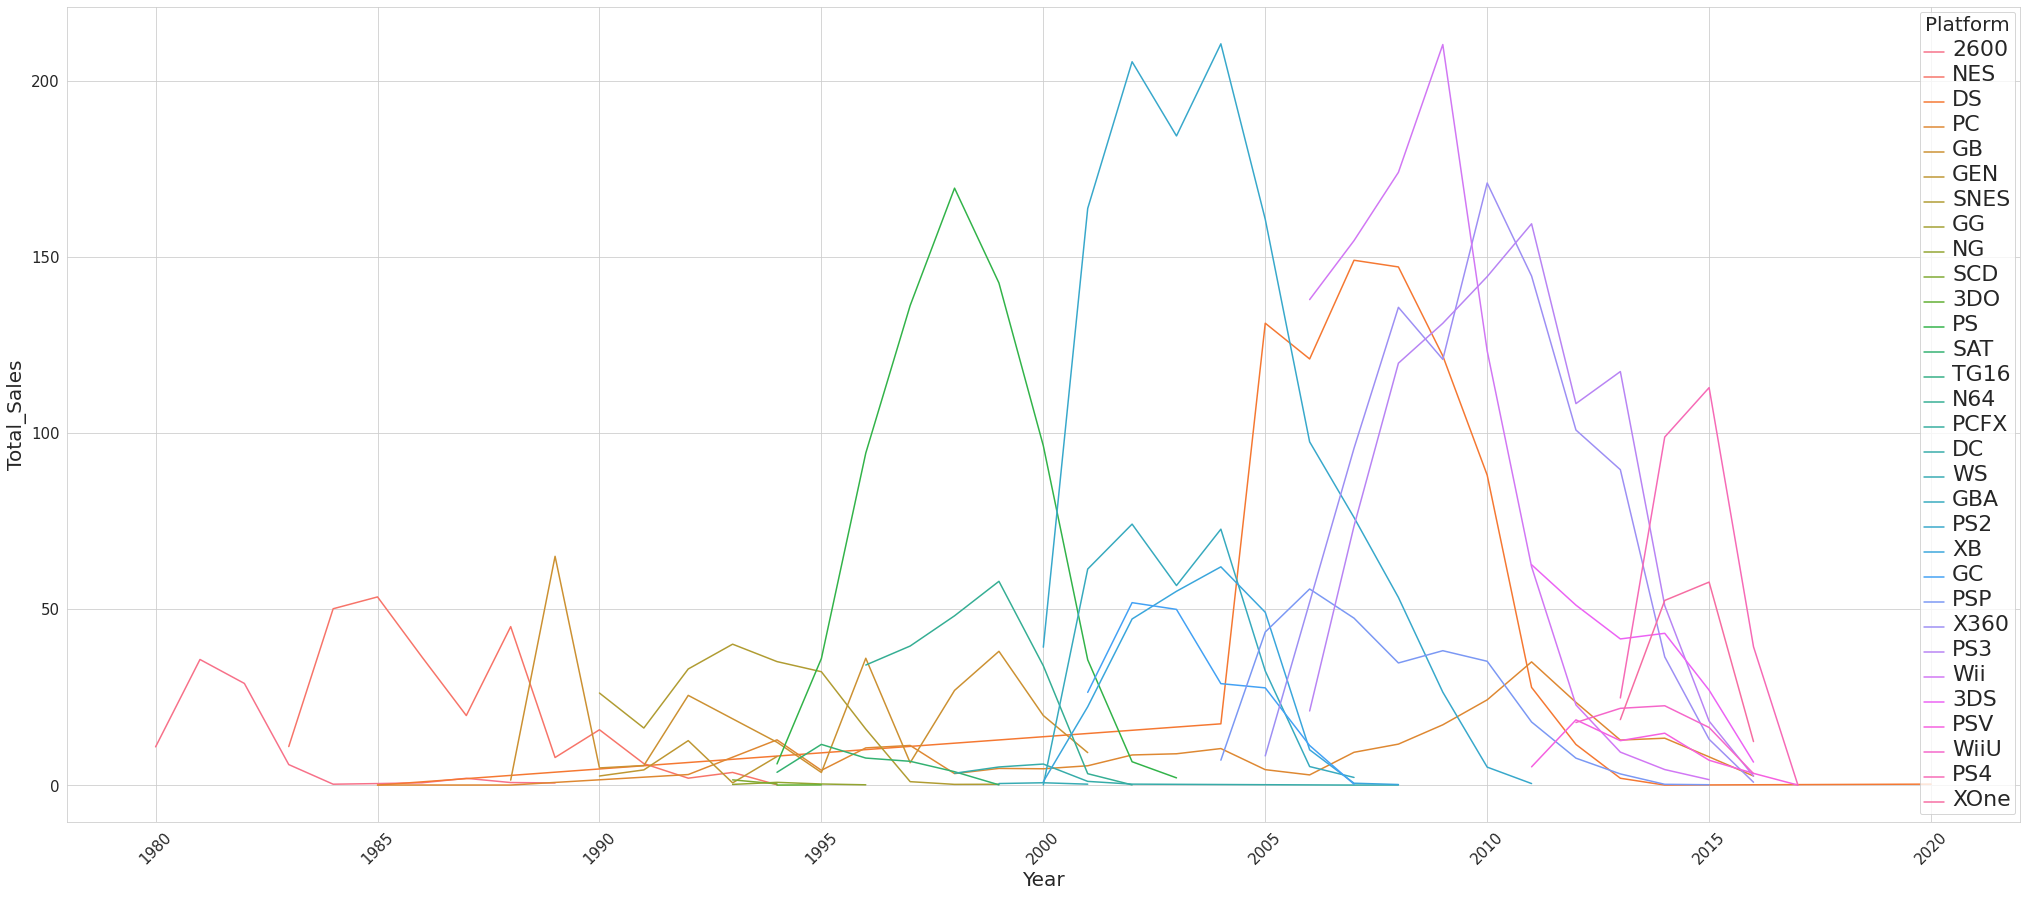

In [17]:
# 연도별 가장 많이 팔린 플랫폼
df_yr_plat = df.groupby(['Year', 'Platform']).sum()[['Total_Sales']].reset_index()

# 막대 그래프로 시각화
plt.figure(figsize=(35, 15))
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Total_Sales", fontsize = 20)
ax = sns.lineplot(data = df_yr_plat, x= "Year", y= "Total_Sales", hue = 'Platform')
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.set_style('whitegrid')

In [18]:
# 장르와 플랫폼 카이제곱 검정
# 귀무 가설 : 서로 독립이다. 연관성이 없다.
# 대립 가설 : 서로 종속된다. 연관성이 있다.

cross_gen_plt = pd.crosstab(df['Genre'], df['Platform'])
hi2_1, pv_1, dof_1, exp_1 = stats.chi2_contingency(cross_gen_plt)
pv_1  # < 0.05 이므로 서로 종속된다. 연관성이 있다.

0.0

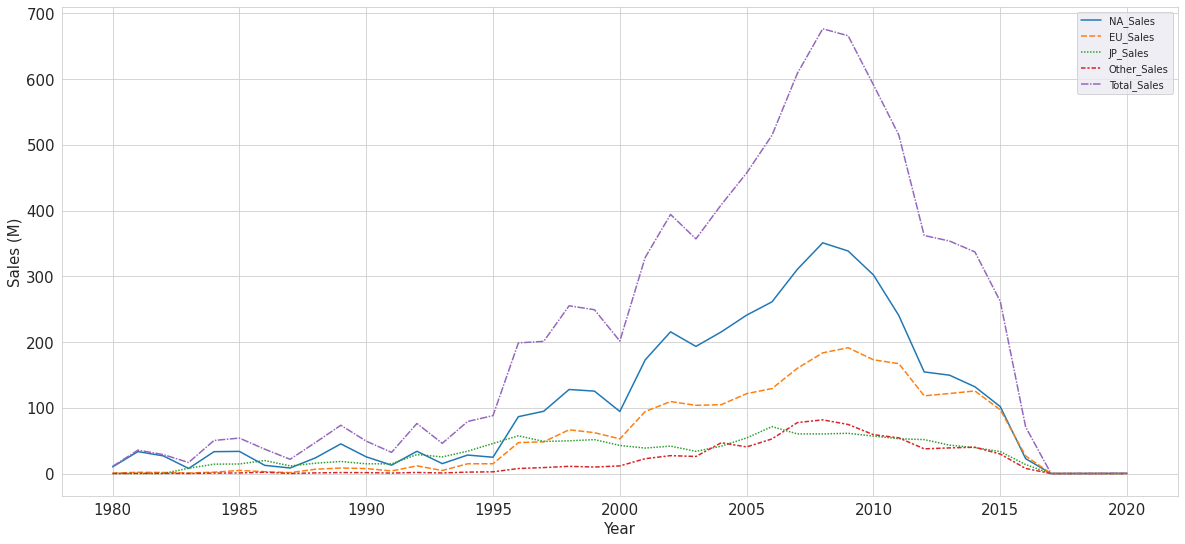

In [19]:
# 연도별 각 지역 출고량
df_yr = df.groupby('Year').sum()

# 라인 그래프로 시각화
plt.figure(figsize=(20, 9))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Sales (M)", fontsize = 15)
sns.set_style("darkgrid")

sns.lineplot(data=df_yr);
# 게임 판매량이 NA가 제일 높고, 그 다음 EU 이다.
sns.set_style('whitegrid')

In [20]:
# 북미와 유럽 간의 게임 출고량 차이 검정하기
df_na = df['NA_Sales']
df_eu = df['EU_Sales']
df_jp = df['JP_Sales']
df_ot = df['Other_Sales']

stats.ttest_ind(df_na, df_eu) # < 0.05 이므로 북미 출고량 평균과 유럽 출고량 평균이 같지 않다.

Ttest_indResult(statistic=15.529431683779592, pvalue=3.4366032446572956e-54)

In [21]:
# 지역 간 게임 출고량 차이 검정하기 

stats.f_oneway(df_na, df_eu, df_jp, df_ot) # < 0.05 이므로 지역 간 게임 출고량 평균의 차이가 있다.

F_onewayResult(statistic=565.496803722431, pvalue=0.0)

## 질문 3 > 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

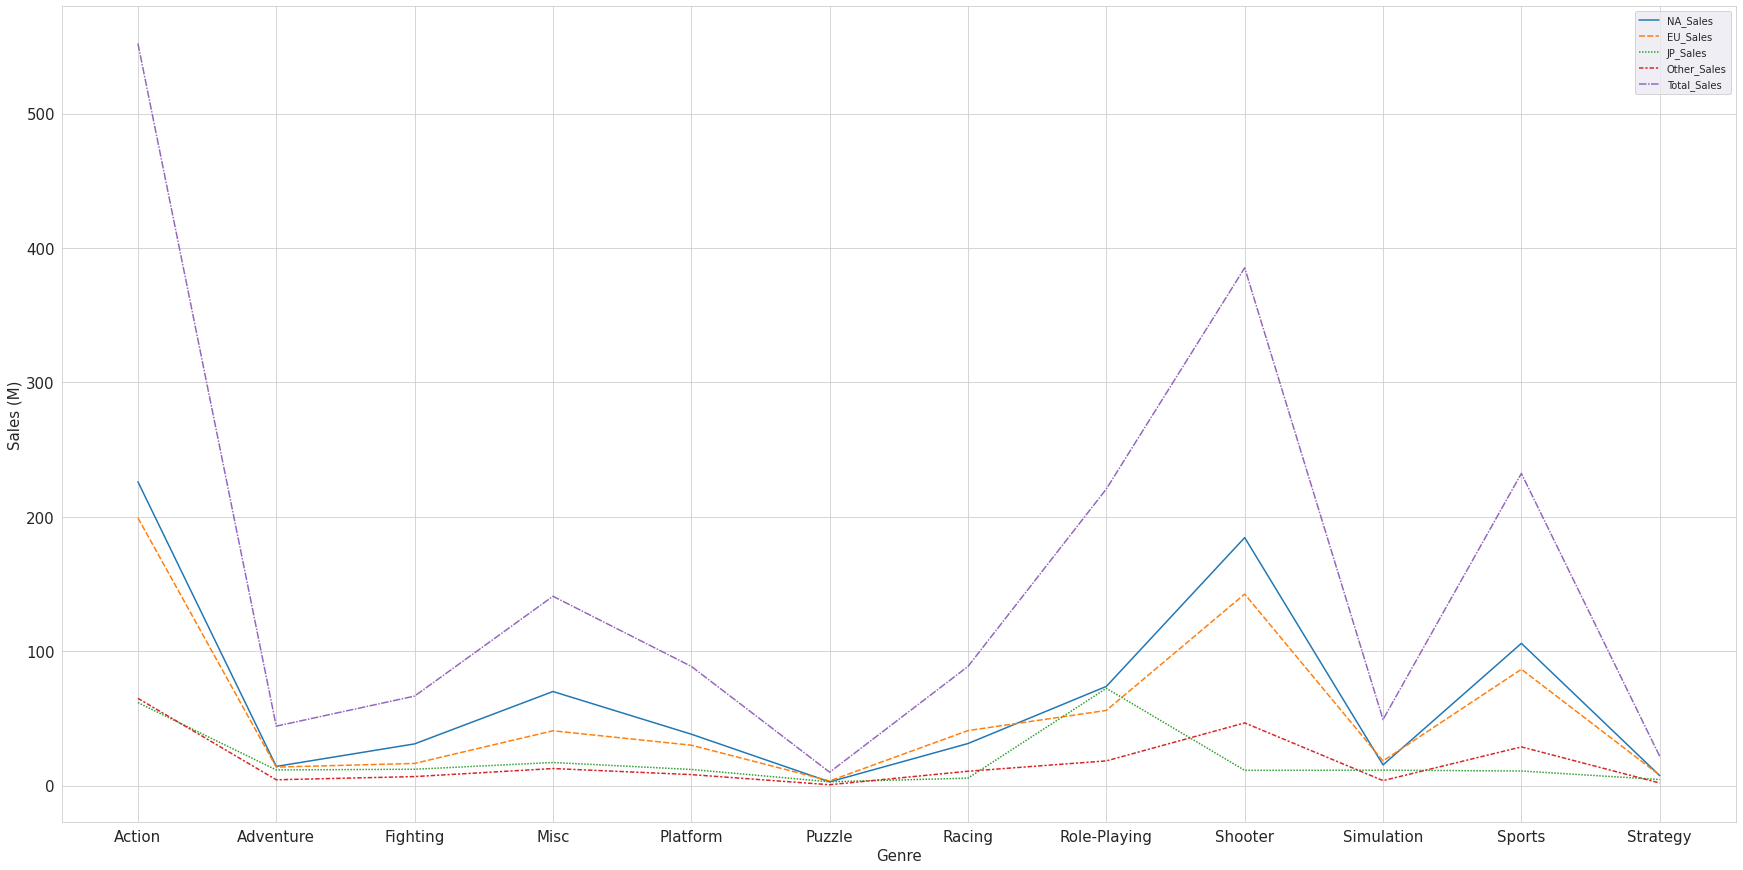

In [22]:
# 최근 10년 간 지역별 장르 선호도
df_genre = df[df['Year'] > 2010].groupby('Genre').sum().drop(columns = 'Year')

plt.figure(figsize=(30, 15))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("Sales (M)", fontsize = 15)
sns.set_style("darkgrid")

sns.lineplot(data=df_genre);
sns.set_style('whitegrid')

In [23]:
# NA : Action - Shooter - Sports
# EU : Action - Shooter - Sports
# JP : Role-Playing - Action
# Other : Action - Shooter - Sports

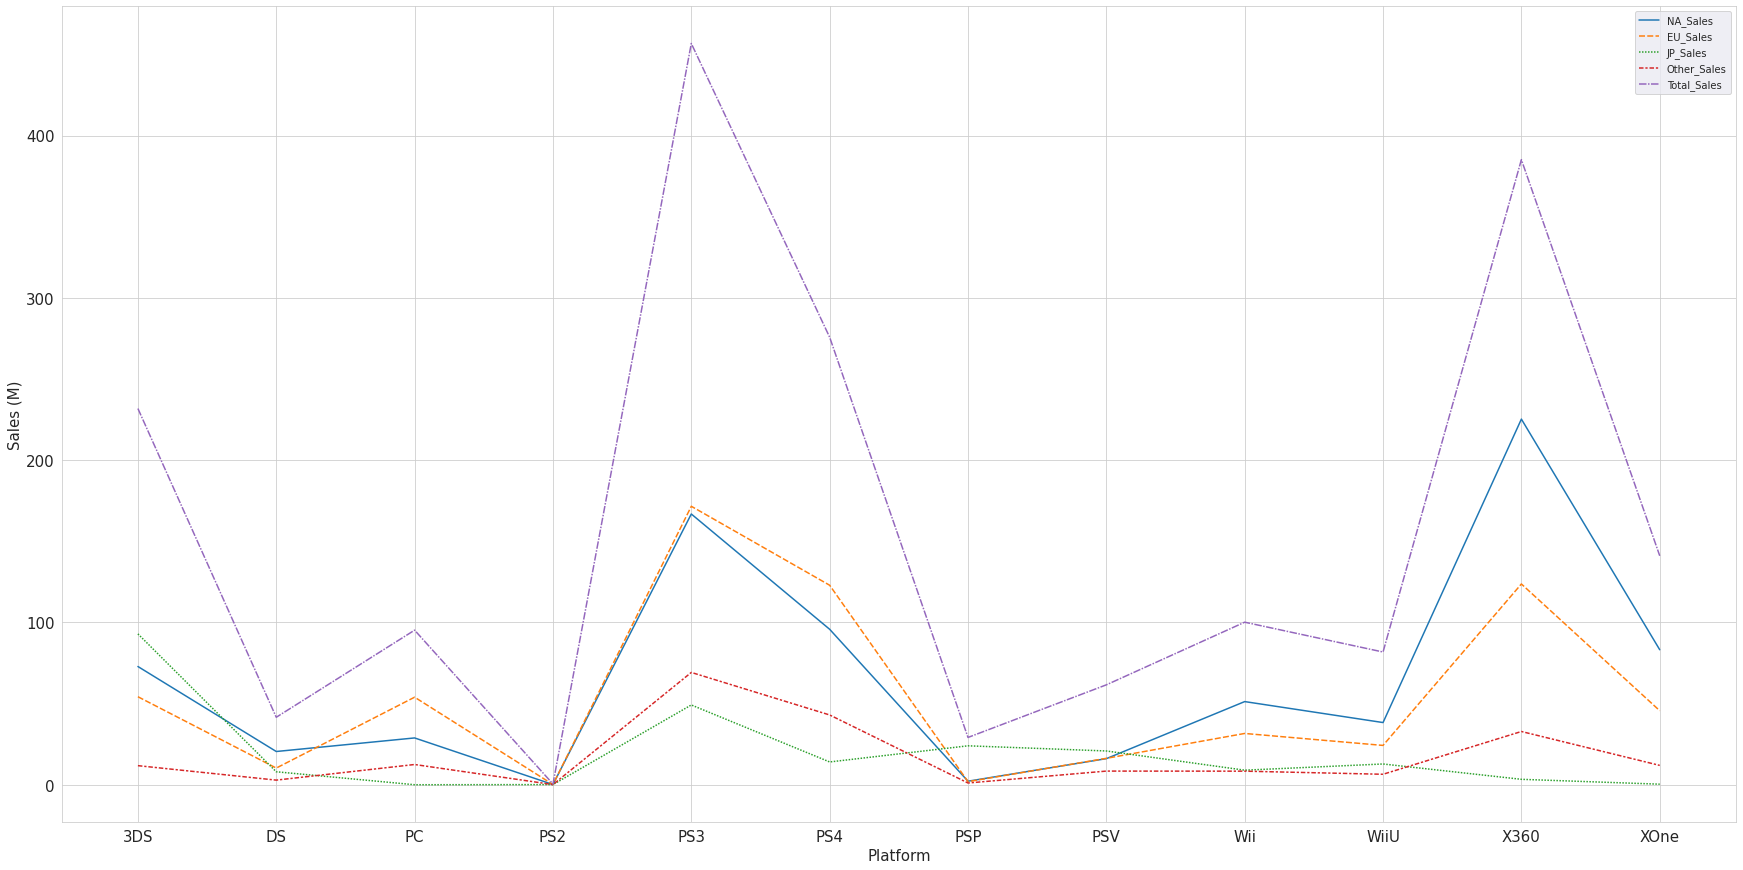

In [24]:
# 최근 10년 간 지역별 플랫폼 선호도
df_platform = df[df['Year'] > 2010].groupby('Platform').sum().drop(columns = 'Year')

plt.figure(figsize=(30, 15))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Platform", fontsize = 15)
plt.ylabel("Sales (M)", fontsize = 15)
sns.set_style("darkgrid")

sns.lineplot(data=df_platform);
sns.set_style('whitegrid')

In [25]:
# NA : X360 - PS3 - XOne
# EU : PS3 - X360 - XOne
# JP : 3DS - PS3
# Other : PS3 - PS4 - X360

### 최근 10년 간 북미 게임 출고량 TOP 10 워드 클라우드

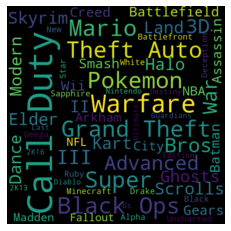

In [26]:
# 최근 10년 간 북미 게임 출고량 TOP 10
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_na_top = df[(df['Year'] > 2010)].sort_values('NA_Sales', ascending=False)[:50]

# Create a list of word
text= ' '.join(df_na_top['Name'])

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show() # Call of Duty, GTA

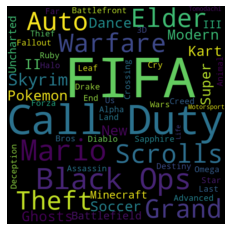

In [27]:
# 최근 10년 간 유럽 게임 출고량 TOP 10
df_eu_top = df[(df['Year'] > 2010)].sort_values('EU_Sales', ascending=False)[:50]

text= ' '.join(df_eu_top['Name'])

wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show() # GTA, Call of Duty, FIFA

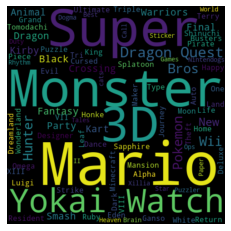

In [28]:
# # 최근 10년 간 일본 게임 출고량 TOP 10
df_jp_top = df[(df['Year'] > 2010)].sort_values('JP_Sales', ascending=False)[:50]

text= ' '.join(df_jp_top['Name'])

wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show() # Pokemon

In [29]:
# 북미 Top 50 장르와 유럽 Top 50 장르 간의 카이 제곱 검정

cross_na_eu_gen = pd.crosstab(df_na_top['Genre'], df_eu_top['Genre'])
hi2_2, pv_2, dof_2, exp_2 = stats.chi2_contingency(cross_na_eu_gen)
pv_2  # < 0.05 이므로 서로 종속된다. 연관성이 있다.

1.1806555180556265e-21

In [30]:
# 북미 Top 50 플랫폼과 유럽 Top 50 플랫폼 간의 카이 제곱 검정

cross_na_eu_plt = pd.crosstab(df_na_top['Platform'], df_eu_top['Platform'])
hi2_3, pv_3, dof_3, exp_3 = stats.chi2_contingency(cross_na_eu_plt)
pv_3  # < 0.05 이므로 서로 종속된다. 연관성이 있다.

3.2833138037341095e-24

### 인기 장르의 플랫폼별 출고량 

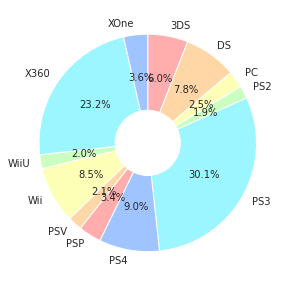

In [31]:
# Action 장르의 플랫폼 선호도 (총 출고량)
df_act_plt = pd.DataFrame(df[(df['Year'] > 2007) & (df['Genre'] == 'Action')]).groupby('Platform').sum()
df_act_plt = df_act_plt[['Total_Sales']].reset_index()

values = df_act_plt['Total_Sales']
labels = df_act_plt['Platform']
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']

plt.figure(figsize=(5, 5))
plt.pie(values, labels = labels, autopct = '%.1f%%', startangle = 90, counterclock=False, colors = colors);
my_circle=plt.Circle( (0,0), 0.3, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show();
# PS3 > X360 > PS4

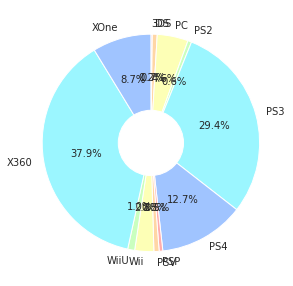

In [32]:
# Shooter 장르의 플랫폼 선호도 (총 출고량)
df_shoot_plt = pd.DataFrame(df[(df['Year'] > 2007) & (df['Genre'] == 'Shooter')].groupby('Platform').sum())
df_shoot_plt = df_shoot_plt[['Total_Sales']].reset_index()

values = df_shoot_plt['Total_Sales']
labels = df_shoot_plt['Platform']
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']

plt.figure(figsize=(5, 5))
plt.pie(values, labels = labels, autopct = '%.1f%%', startangle = 90, counterclock=False, colors = colors);
my_circle=plt.Circle( (0,0), 0.3, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show();
# X360 > PS3 > PS4

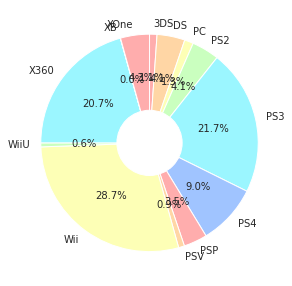

In [33]:
# Sports 장르의 플랫폼 선호도 (총 출고량)
df_sport_plt = pd.DataFrame(df[(df['Year'] > 2007) & (df['Genre'] == 'Sports')].groupby('Platform').sum())
df_sport_plt = df_sport_plt[['Total_Sales']].reset_index()

values = df_sport_plt['Total_Sales']
labels = df_sport_plt['Platform']
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']

plt.figure(figsize=(5, 5))
plt.pie(values, labels = labels, autopct = '%.1f%%', startangle = 90, counterclock=False, colors = colors);
my_circle=plt.Circle( (0,0), 0.3, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show();
# PS3 > PS4 > X360

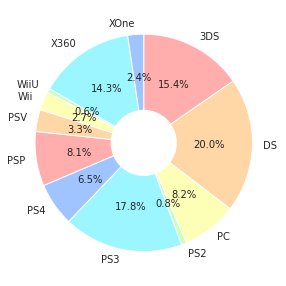

In [34]:
# Role-Playing 장르의 플랫폼 선호도 (총 출고량)
df_role_plt = pd.DataFrame(df[(df['Year'] > 2007) & (df['Genre'] == 'Role-Playing')].groupby('Platform').sum())
df_role_plt = df_role_plt[['Total_Sales']].reset_index()

values = df_role_plt['Total_Sales']
labels = df_role_plt['Platform']
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']

plt.figure(figsize=(5, 5))
plt.pie(values, labels = labels, autopct = '%.1f%%', startangle = 90, counterclock=False, colors = colors);
my_circle=plt.Circle( (0,0), 0.3, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show();
# 3DS > PS3

### 인기 장르와 인기 플랫폼 게임의 지역별 출고량

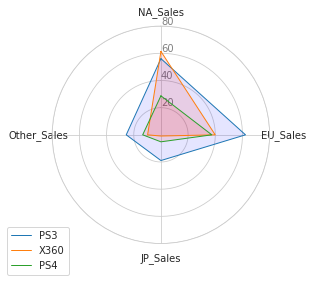

In [35]:
 # 미국 1순위, 유럽 1순위, 그 외 나라 1순위, 일본 2순위 인 Action 장르
 # Action 장르 인기 플랫폼(PS3 > X360 > PS4)의 지역별 출고량

from math import pi

df_act_ = df[(df['Genre'] == 'Action') & (df["Year"] > 2010)].groupby('Platform').sum().drop(columns = ['Year', 'Total_Sales'])
df_act_ = df_act_.loc[['PS3', 'X360', 'PS4'], :].reset_index()
df_act_

categories=list(df_act_)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60, 80], ["20","40","60", "80"], color="grey", size=10)
plt.ylim(0,80)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df_act_.loc[0].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS3")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_act_.loc[1].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="X360")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df_act_.loc[2].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS4")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('Action 장르 인기 플랫폼의 지역별 출고량.png', dpi = 100)
# Show the graph
plt.show()

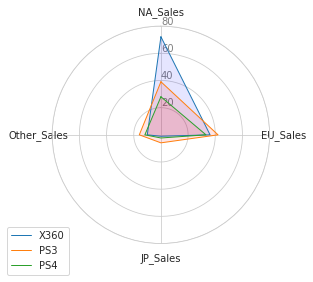

In [36]:
# 미국 2순위, 유럽 2순위, 그 외 나라 2순위 인 Shooter 장르
# Shooter 장르 인기 플랫폼(X360 > PS3 > PS4)의 지역별 출고량

df_shoot_ = df[(df['Genre'] == 'Shooter') & (df["Year"] > 2010)].groupby('Platform').sum().drop(columns = ['Year', 'Total_Sales'])
df_shoot_ = df_shoot_.loc[['X360', 'PS3', 'PS4'], :].reset_index()
df_shoot_

categories=list(df_shoot_)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60, 80], ["20","40","60", "80"], color="grey", size=10)
plt.ylim(0,80)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df_shoot_.loc[0].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="X360")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_shoot_.loc[1].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS3")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df_shoot_.loc[2].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS4")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('Shooter 장르 인기 플랫폼의 지역별 출고량.png', dpi = 100)
# Show the graph
plt.show()

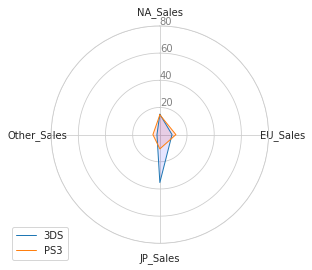

In [37]:
# 일본 1순위인 Role-Playing 장르
# Role-Playing 장르 인기 플랫폼(3DS > PS3)의 지역별 출고량

df_role_ = df[(df['Genre'] == 'Role-Playing') & (df["Year"] > 2010)].groupby('Platform').sum().drop(columns = ['Year', 'Total_Sales'])
df_role_ = df_role_.loc[['3DS', 'PS3'], :].reset_index()
df_role_

categories=list(df_role_)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60, 80], ["20","40","60", "80"], color="grey", size=10)
plt.ylim(0,80)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df_role_.loc[0].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="3DS")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_role_.loc[1].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS3")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

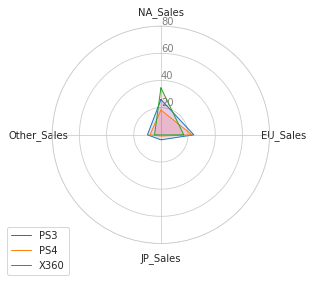

In [38]:
# 미국 3순위, 유럽 3순위, 그 외 나라 3순위 Sports 장르
# Sports 장르 인기 플랫폼(PS3 > PS4 > X360)의 지역별 출고량

df_sports_ = df[(df['Genre'] == 'Sports') & (df["Year"] > 2010)].groupby('Platform').sum().drop(columns = ['Year', 'Total_Sales'])
df_sports_ = df_sports_.loc[['PS3', 'PS4', 'X360'], :].reset_index()
df_sports_

categories=list(df_sports_)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60, 80], ["20","40","60", "80"], color="grey", size=10)
plt.ylim(0,80)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df_sports_.loc[0].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS3")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_sports_.loc[1].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PS4")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df_sports_.loc[2].drop('Platform').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="X360")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

## 결론 > 다음 분기에 어떤 게임을 설계해야할까? 

In [39]:
# 다음 분기 게임 설계

# 북미 : Shooter & X360 
# 유럽 : Action & PS3
# 일본 : Role-Playing & 3DS
# 그 외 나라 : Action & PS3